In [1]:
import fourierseries
import util
import phaser
import dataloader
# Preprocess data for a single subject - to be send to modeling frameworks
def find_phase(k):
    """
    Detrend and compute the phase estimate using Phaser
    INPUT:
      k -- dataframe
    OUTPUT:
      k -- dataframe
    """
    #l = ['hip_flexion_l','hip_flexion_r'] # Phase variables = hip flexion angles
    y = np.array(k)
    print(y.shape)
    y = util.detrend(y.T).T
    print(y.shape)
    phsr = phaser.Phaser(y=y)
    k[:] = phsr.phaserEval(y)[0,:]
    return k


Running phaser


In [2]:
import os
import scipy.io
import argparse
import logging
import time
import numpy as np
import numpy.random as npr
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchdiffeq import odeint_adjoint as odeint
from torch.utils.data import DataLoader
os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [3]:
datafilepath = 'C:/Users/shiny/Documents/NeuralODE_HumanGait/Humangaitdata.npy'
data = np.load(datafilepath)

In [4]:
X = data.copy()

In [5]:
def vonMies(t,t_0, b):
    out = np.exp(b*np.cos(t-t_0))/(2*pi*iv(0, b))
    return out

In [6]:
X = X[:, 200:1350,:]

In [7]:
X = X.reshape(72 * 1150, 6)

In [8]:
self_drive = 1150
tot_len  = 72
HC_CellArray = np.empty(shape=[tot_len, self_drive, X.shape[1]])
start = 0
last = self_drive # length of trials
for p in range(tot_len):
    HC_CellArray[p]= X[start:last]
    start = start+self_drive
    last = last+self_drive

In [9]:
from scipy.signal import find_peaks
from scipy import interpolate
from scipy.special import iv
from numpy import sin,cos,pi,array,linspace,cumsum,asarray,dot,ones
from pylab import plot, legend, axis, show, randint, randn, std,lstsq

In [10]:
print('generating phase averaged signatures')
# phase length = 100
lim = tot_len
L = 6 # lets look at 1st 6 to speed things up #numunits*2  # number of PCs or units to be phase averaged
PhaseAveragedPCs = np.empty(shape=[lim, L, 100])
PhaseAveragedPCs_shift = np.empty(shape=[lim, L, 100])
Phase_Variables = np.empty(shape=[lim, self_drive])
cyclephase = []
PC_Shifts = np.empty(shape=[lim]) # store phase shift values
# Average orbits initialization
numSegments = 100 # we want each Phase averaged orbit to be 100 sample points long
phaseVals = np.linspace(0, 2*pi, numSegments, endpoint=True) # phases that we want our phase averaged orbits to correspond to
kappa = 20 

for a in range(lim): #for length of all the trials 
    trialnum = a+1
    print(['processing trial: ' + str(trialnum)]) 
    dats=[] # reset variables after each trial - kinematics
    dats2 = [] # reset the HC params
    allsigs = np.empty(shape=[100,])
    all_phase_var = np.empty(shape=[100,]) 
    PhaseAvgPCs = np.empty(shape=[100])
    all_cyclephase = []
    raw = HC_CellArray[a][:,0:6].T # Only use 1st 3 PCs (of HCs),
    raw2 = HC_CellArray[a][:,0:6].T  # extract all the HC data
    for b in range(6): #Shai's code does this duplication- works better than without duplicating data
        dats.append(raw-raw.mean(axis=1)[:,np.newaxis]) #center the HCs data for phase estimation -- this centers each one separately
        dats2.append(raw2-raw2.mean(axis=1)[:,np.newaxis])
    #rHC = dats2[0] #centered data
    rHC = raw2 #uncentered data
    phr = phaser.Phaser(dats) # use centered data from 1st 3 PCs
    phi = [ phr.phaserEval( d ) for d in dats ] # extract phase
    phi2  =(phi[0].T % (2*pi)); # Take modulo s.t. phase ranges from [0,2*pi]

    # find average orbits
    avgOrbits = np.zeros((numSegments,L)) #initialize avg orbits
    phases = np.reshape(phi2,[self_drive,]) 

    for c in range(numSegments): #number of points in final average orbit/phase averaging
        vonMiesCurrent = vonMies(phases,phaseVals[c],kappa) # for each value of phase points calculate current
        sumVal = np.sum(vonMiesCurrent)

        for d in range(L):  # for the number of features or units
            #data = np.reshape(rHC[d,:],[trialsamp,1])
            data = np.reshape(rHC[d,:],[self_drive,1])
            avgOrbits[c,d] = np.sum(data.T*vonMiesCurrent)/sumVal # phase point (row), feature of PC (column) -- this is generating a value for the 1st phase point of each feature

    PhaseAveragedPCs[a] = avgOrbits.T # transform to match overall saving structure as before
    phi2 = phi2.reshape(self_drive,)
    Phase_Variables[a] = phi2 # store phase variables for all cycles/features - may need to phase shift these 

    # Phase shift the data according to PC1 max align with zero phase
    PC1_maxloc = np.argmax(PhaseAveragedPCs[a][0]) # identify the max PC1 value (1st max if repeated)
    Data2Shift = PhaseAveragedPCs[a] 
    NewP = np.roll(Data2Shift, -PC1_maxloc,axis=1) #shift data so that PC1 max is at the orgin - this is defined as zero phase
    PC_Shifts[a] = PC1_maxloc
    PhaseAveragedPCs_shift[a] = NewP #store shifted data


generating phase averaged signatures
['processing trial: 1']


C:\Users\shiny\Documents\NeuralODE_HumanGait\phaser.py:399: UserWarning: PhaserForSample:nCycMismatch
  warnings.warn( "PhaserForSample:nCycMismatch" )


['processing trial: 2']
['processing trial: 3']
['processing trial: 4']
['processing trial: 5']
['processing trial: 6']
['processing trial: 7']
['processing trial: 8']
['processing trial: 9']
['processing trial: 10']
['processing trial: 11']
['processing trial: 12']
['processing trial: 13']
['processing trial: 14']
['processing trial: 15']
['processing trial: 16']
['processing trial: 17']
['processing trial: 18']
['processing trial: 19']
['processing trial: 20']
['processing trial: 21']
['processing trial: 22']
['processing trial: 23']
['processing trial: 24']
['processing trial: 25']
['processing trial: 26']
['processing trial: 27']
['processing trial: 28']
['processing trial: 29']
['processing trial: 30']
['processing trial: 31']
['processing trial: 32']
['processing trial: 33']
['processing trial: 34']
['processing trial: 35']
['processing trial: 36']
['processing trial: 37']
['processing trial: 38']
['processing trial: 39']
['processing trial: 40']
['processing trial: 41']
['proces

C:\Users\shiny\Documents\NeuralODE_HumanGait\phaser.py:397: UserWarning: PhaserForSample:tooShort
  warnings.warn( "PhaserForSample:tooShort" )


['processing trial: 44']
['processing trial: 45']
['processing trial: 46']
['processing trial: 47']
['processing trial: 48']
['processing trial: 49']
['processing trial: 50']
['processing trial: 51']
['processing trial: 52']
['processing trial: 53']
['processing trial: 54']
['processing trial: 55']
['processing trial: 56']
['processing trial: 57']
['processing trial: 58']
['processing trial: 59']
['processing trial: 60']
['processing trial: 61']
['processing trial: 62']
['processing trial: 63']
['processing trial: 64']
['processing trial: 65']
['processing trial: 66']
['processing trial: 67']
['processing trial: 68']
['processing trial: 69']
['processing trial: 70']
['processing trial: 71']
['processing trial: 72']


In [10]:
graphpath = 'data_results/Original_Data_exc100/'

if not os.path.exists(graphpath):
   os.makedirs(graphpath)

In [41]:
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(18, 9))
axes = axes.flatten()
for j in range(6):
    ts_pos_combined =  np.linspace(0, 99, num=100) 

    K = np.int32(np.linspace(6*j, 6*j+5, num = 6))
    
    for i, ax in enumerate(axes[K]):
            ax.plot(ts_pos_combined[0:100], PhaseAveragedPCs[K[i], i, 0:100], 'r')


plot_name = 'phaseavg_Human0.png'
save_path = os.path.join(graphpath, plot_name)
plt.savefig(save_path, dpi=500)
plt.close()

## This is it for multiple people

In [48]:
num_patient = 12
num_trial_per_patient = 6

for p in range(num_patient):
    fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(18, 9))
    axes = axes.flatten()
    for j in range(num_trial_per_patient):
        ts_pos_combined =  np.linspace(0, 99, num=100) 

        K = np.int32(np.linspace(6*j, 6*j+5, num = 6))
        Q = np.int32(np.linspace(6*p, 6*p+5, num = 6))

        for i, ax in enumerate(axes[K]):
            ax.plot(ts_pos_combined[0:100], PhaseAveragedPCs[Q[j], i, 0:100], 'r')


    plot_name = 'phaseavg_Human{}.png'.format(p)
    save_path = os.path.join(graphpath, plot_name)
    plt.savefig(save_path, dpi=500)
    plt.close()

In [11]:
savepath = 'data_results/Original_startpointsame/'

if not os.path.exists(savepath):
   os.makedirs(savepath)

mod_name = 'exc_100'

np.save(savepath + mod_name + '_PhaseAvg_Original.npy', PhaseAveragedPCs) #unshifted
scipy.io.savemat(savepath + mod_name + '_PhaseAvg_Originaln.mat', {'PhaseAvgPCs': PhaseAveragedPCs})

np.save(savepath + mod_name + '_PhaseAvg_Original_shift.npy', PhaseAveragedPCs_shift) #shifted to set phase = 0 as the max of PC1
scipy.io.savemat(savepath + mod_name + '_PhaseAvg_Original_shift.mat', {'PhaseAvgPCs_shift': PhaseAveragedPCs_shift})

np.save(savepath + mod_name + '_PhaseVariables_Original.npy', Phase_Variables)
scipy.io.savemat(savepath + mod_name + '_PhaseVariables_Original.mat', {'PhaseVariables': Phase_Variables})

In [50]:
# Concatenate gait signature per trial
# Make a single phase averaged signature per row
PA_shape = PhaseAveragedPCs_shift.shape
gait_sig_size = PA_shape[1]*PA_shape[2]
Gaitsignatures = np.empty(shape = [len(PhaseAveragedPCs_shift),gait_sig_size]) # Store gait signatures
Gaitsignatures_trunc6 = np.empty(shape = [len(PhaseAveragedPCs_shift),600]) # Store truncated version of gait signatures to the first 6 PCs
for h in range(len(PhaseAveragedPCs_shift)):
    reshape_sig = PhaseAveragedPCs_shift[h].reshape(1,gait_sig_size)
    Gaitsignatures[h] = reshape_sig[0]
    Gaitsignatures_trunc6[h] = reshape_sig[0][0:600] #truncate to 1st 6 PCs
np.save(savepath + mod_name + '_Gaitsignatures.npy', Gaitsignatures)
scipy.io.savemat(savepath + mod_name + '_Gaitsignatures.mat', {'GaitSigs': Gaitsignatures})

np.save(savepath + mod_name + '_Gaitsignatures_trunc6.npy', Gaitsignatures_trunc6)
scipy.io.savemat(savepath + mod_name + '_Gaitsignatures_trunc6.mat', {'GaitSigs': Gaitsignatures_trunc6})


In [56]:
test_ind = np.arange(0, 72, 1)

In [61]:
import csv
from sklearn.manifold import MDS

In [60]:
path = 'C://Users/shiny/Documents/NeuralODE_HumanGait/'
datafilepath3 = path + 'SpeedLabels.mat'
speedlabels = scipy.io.loadmat(datafilepath3)
speedlist = []
for m in test_ind:
    speedlist.append(speedlabels['SpeedTrainTrials'][m][0][0][0])

# Import Subject Labels
myfile = path + 'Subjectlabels.csv'
csvfile = open(myfile, 'r')
reader = csv.reader(csvfile, delimiter='\t')
allsubs = list(reader)
select_subs = map(allsubs.__getitem__, test_ind)
subs= list(select_subs)

C:\Users\shiny\anaconda3\envs\pytorch-gpu\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
C:\Users\shiny\AppData\Local\Temp\ipykernel_23304\4171916428.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster')


<IPython.core.display.Javascript object>


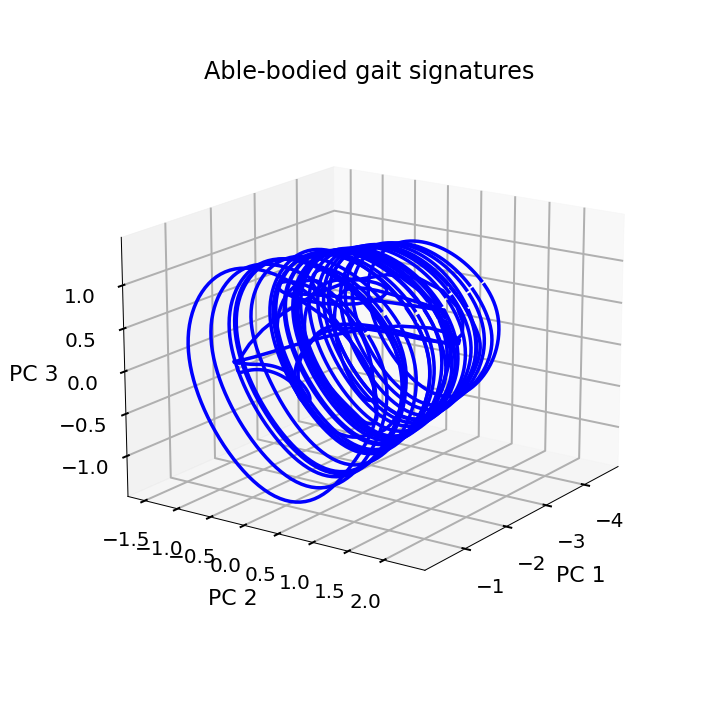

<IPython.core.display.Javascript object>


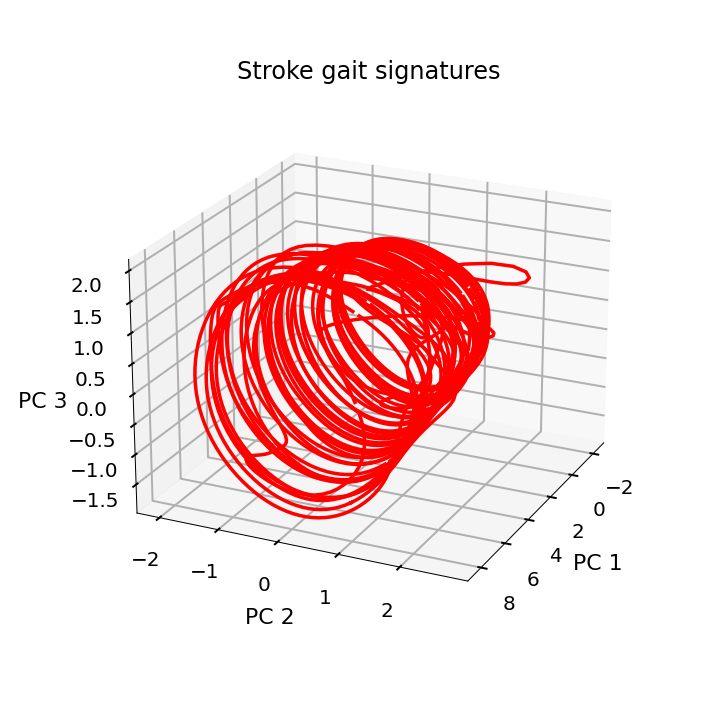

In [62]:


# Mutlidimensional scaling of gait signatures
embedding = MDS(n_components=2)
X_transformed = embedding.fit_transform(Gaitsignatures_trunc6) # Perform MDS on 6D gait signatures to visualize in 2D
np.save(savepath + mod_name + '_MDS_X_transformed.npy', X_transformed)

# MDS plots of ext and self sigs
fig = plt.figure()
plt.scatter(X_transformed[:,0],X_transformed[:,1],c = speedlist) # color 2D gait signatures according to speed
# Loop for annotation of all points
count = 0
for i in range(len(subs)):
    plt.annotate(str(count), (X_transformed[i,0], X_transformed[i,1] + 0.3)) # annotate subject ID next to the 2D gait signatures
    count = count + 1    
plt.savefig(savepath + mod_name +  '_MDS.png', dpi = 300)
#plt.close(fig)# close figure in loop
plt.style.use('seaborn-poster')

%matplotlib notebook

# Plot Able-bodied Gait Signatures (3D loops)
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')
ax.grid()
for k in range(30):
  PC1 = Gaitsignatures_trunc6[k,0:100]
  PC2 = Gaitsignatures_trunc6[k,100:200]
  PC3 = Gaitsignatures_trunc6[k,200:300]
  ax.plot3D(PC1, PC2, PC3,'b')
ax.set_title('Able-bodied gait signatures')

# Set axes label
ax.set_xlabel('PC 1', labelpad=20)
ax.set_ylabel('PC 2', labelpad=20)
ax.set_zlabel('PC 3', labelpad=20)

plt.savefig(savepath + mod_name +  '_GaitSignatures_AbleBodied.png', dpi = 300)
plt.show()

# Plot Stroke Gait Signatures (3D loops)
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')
ax.grid()
for k in range(42):
  PC1 = Gaitsignatures_trunc6[k+30,0:100]
  PC2 = Gaitsignatures_trunc6[k+30,100:200]
  PC3 = Gaitsignatures_trunc6[k+30,200:300]
  ax.plot3D(PC1, PC2, PC3,'r')
ax.set_title('Stroke gait signatures')

# Set axes label
ax.set_xlabel('PC 1', labelpad=20)
ax.set_ylabel('PC 2', labelpad=20)
ax.set_zlabel('PC 3', labelpad=20)

plt.savefig(savepath + mod_name +  '_GaitSignatures_Stroke.png', dpi = 300)
plt.show()